## Vehicle Image Classification

Dataset source: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification

8 classes :
- Auto Rickshaws (800 images)
- Bikes (800 images)
- Cars (790 images)
- Motorcycles (800 images)
- Planes (800 images)
- Ships (800 images)
- Trains (800 images)

Total = 5590 images

Transfer learning using pre-trained model (EfficientNet V2)

Reference: https://www.kaggle.com/code/annafabris/efficientnet-v2-image-classification-93-accuracy


Note: some of the corrupted images have been removed & images with incorrect file type has been converted to jpg format (refer to functions in the code)

In [ ]:
import numpy as np
import os
import random
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix

## Split data into train test validation (optional) (only run this if you have not split your dataset)

In [ ]:
# Define dataset path
data_path = r"C:\Users\Anderson Yeo\Downloads\vehicle_dataset_kaggle"

# Define output directories for train, val, and test splits
train_dir = os.path.join(data_path, "train")
val_dir = os.path.join(data_path, "val")
test_dir = os.path.join(data_path, "test")

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Allowed image extensions
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

# Create output directories if they don't exist
for split in [train_dir, val_dir, test_dir]:
    os.makedirs(split, exist_ok=True)

# Iterate over each class folder inside 'vehicle_dataset_kaggle'
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)

    # Ensure it's a directory (not a file)
    if not os.path.isdir(class_path):
        continue

    # Get all valid image files
    images = [f for f in os.listdir(class_path)
              if os.path.isfile(os.path.join(class_path, f))
              and os.path.splitext(f)[1].lower() in valid_extensions]

    # Debugging: Print class info
    print(f"Processing Class: {class_name} | Found {len(images)} images")

    # Skip classes with no images
    if len(images) < 2:
        print(f"⚠️ Skipping '{class_name}' (Not enough images)")
        continue

    # Shuffle images for randomness
    random.shuffle(images)

    # Split dataset
    train_imgs, temp_imgs = train_test_split(images, test_size=(val_ratio + test_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    # Create class subfolders in train, val, and test directories
    for split_dir, img_list in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
        class_split_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_split_dir, exist_ok=True)

        # Move images into respective split directories
        for img in img_list:
            src = os.path.join(class_path, img)
            dest = os.path.join(class_split_dir, img)
            shutil.move(src, dest)

print("✅ Dataset splitting completed successfully!")


Processing Class: Auto Rickshaws | Found 800 images
Processing Class: Bikes | Found 800 images
Processing Class: Cars | Found 790 images
Processing Class: Motorcycles | Found 800 images
Processing Class: Planes | Found 798 images
Processing Class: Ships | Found 800 images
Processing Class: test | Found 0 images
⚠️ Skipping 'test' (Not enough images)
Processing Class: train | Found 0 images
⚠️ Skipping 'train' (Not enough images)
Processing Class: Trains | Found 800 images
Processing Class: val | Found 0 images
⚠️ Skipping 'val' (Not enough images)
✅ Dataset splitting completed successfully!


## Remove corrupted/unsupported file (optional)

In [ ]:
dataset_path = r"C:\Users\Anderson Yeo\Downloads\vehicle_dataset_kaggle"  # Update if needed

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify the image integrity
        except (IOError, SyntaxError) as e:
            print(f"Corrupt/unsupported file removed: {file_path}")
            os.remove(file_path)  # Remove corrupted file


In [ ]:
def remove_corrupt_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Check if the file is valid
            except (IOError, SyntaxError):
                print(f"Removing corrupt or unsupported image: {file_path}")
                os.remove(file_path)

# Run for train, validation, and test directories (if necessary)
# remove_corrupt_images(train_path)
#remove_corrupt_images("/content/vehicle_dataset_kaggle/val")
#remove_corrupt_images("/content/vehicle_dataset_kaggle/test")

## Change file type to jpg (optional)

In [15]:
def convert_images_to_jpg(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    rgb_img = img.convert("RGB")  # Convert to RGB mode
                    new_file_path = file_path.rsplit(".", 1)[0] + ".jpg"
                    rgb_img.save(new_file_path, "JPEG")
                    if file_path != new_file_path:
                        os.remove(file_path)  # Remove the old file if needed
            except Exception as e:
                print(f"Skipping {file_path}: {e}")

# Convert images in all directories
convert_images_to_jpg(train_path)
convert_images_to_jpg(test_path)
convert_images_to_jpg(val_path)


c:\Users\Anderson Yeo\anaconda3\envs\opencv_env\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Skipping C:\Users\Anderson Yeo\Downloads\vehicle_dataset_kaggle\val\Planes\Plane (43).gif: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Anderson Yeo\\Downloads\\vehicle_dataset_kaggle\\val\\Planes\\Plane (43).gif'


## Load data & data augmentation

In [2]:
train_path = r"C:\Users\Anderson Yeo\Downloads\vehicle_dataset_kaggle\train"
test_path = r"C:\Users\Anderson Yeo\Downloads\vehicle_dataset_kaggle\test"
val_path = r"C:\Users\Anderson Yeo\Downloads\vehicle_dataset_kaggle\val"


#data augmentation
imgdata = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 25,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    zoom_range = 0.3,
    horizontal_flip = True,
    brightness_range = [0.6, 1.3],
    fill_mode = 'nearest'
)

batch_size = 32
img_size = (240,240)

train_batches = image_dataset_from_directory(train_path,
                                            image_size = img_size,
                                            batch_size = batch_size,
                                             label_mode='categorical')

test_batches = image_dataset_from_directory(test_path,
                                           image_size = img_size,
                                           batch_size = batch_size,
                                            label_mode='categorical')

valid_batches = image_dataset_from_directory(val_path,
                                            image_size = img_size,
                                            batch_size = batch_size,
                                             label_mode='categorical')




Found 3866 files belonging to 7 classes.
Found 829 files belonging to 7 classes.
Found 829 files belonging to 7 classes.


## EfficientNetB1 Model

In [3]:
model = EfficientNetB1(weights='imagenet',
                       include_top=False,
                       input_shape=(240,240,3))
model.trainable = False
model.summary()

Model: "efficientnetb1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,575,239 (25.08 MB)

## Add custom layers

In [4]:
r_model = Sequential([
    model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
]
)
r_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ (None, 8, 8, 1280)     │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,740,110 (25.71 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 6,575,239 (25.08 MB)

## Compile model

In [14]:
r_model.compile(optimizer = Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## Calculate steps per epoch & validation steps

In [6]:
import math

steps_per_epoch = math.ceil(len(train_batches))
print("Steps per epoch:", steps_per_epoch)

validation_steps = math.ceil(len(valid_batches))
print("Validation steps:", validation_steps)


Steps per epoch: 121
Validation steps: 26


## Tensorboard log dir

In [7]:
log_dir = "logs9/fit"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

## Train model

In [8]:
history = r_model.fit(
    train_batches,
    verbose=1,
    epochs=50,
    validation_data=valid_batches,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback]
)

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8836 - loss: 0.4277 - val_accuracy: 0.9964 - val_loss: 0.0140
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9882 - loss: 0.0358 - val_accuracy: 0.9940 - val_loss: 0.0157
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9949 - loss: 0.0190 - val_accuracy: 0.9952 - val_loss: 0.0166
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9978 - loss: 0.0111 - val_accuracy: 0.9964 - val_loss: 0.0087
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9958 - loss: 0.0083 - val_accuracy: 0.9952 - val_loss: 0.0133
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9983 - loss: 0.0058 - val_accuracy: 0.9964 - val_loss: 0.0092
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9969 - loss: 0.0090 - val_accuracy: 0.9940 - val_loss: 0.0158
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9981 - loss: 0.0053 - val_accu

## Save model

In [16]:
model_path = r"C:\Users\Anderson Yeo\Downloads\intern\efficientnet1.h5"
r_model.save(model_path)
print("Model saved")

Model saved


## Evaluate on test set

In [ ]:
# model.load_weights(model_path)

# !!! if load a model, uncomment the code above this line, and change r_model to model below

accuracy = r_model.evaluate(test_batches,
                          steps=len(test_batches),
                          verbose=1)
print("Test accuracy: ", accuracy[1]*100)
print("Test loss: ", accuracy[0]*100)

26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9976 - loss: 0.0091
Test accuracy:  99.3968665599823
Test loss:  4.0078304708004


## Print out some test images and their true labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


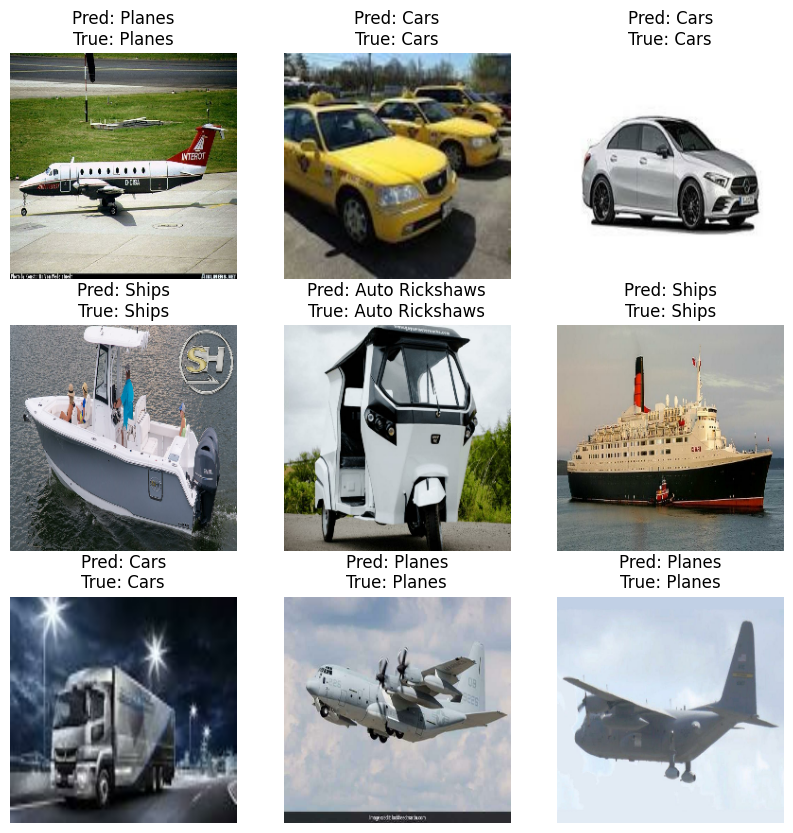

In [79]:
class_names = test_batches.class_names
images, labels = next(iter(test_batches))  # Get one batch
predictions = r_model.predict(images)

plt.figure(figsize=(10, 10))
for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_label = class_names[np.argmax(predictions[i])]
    true_label = class_names[np.argmax(labels[i])]
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()


## Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

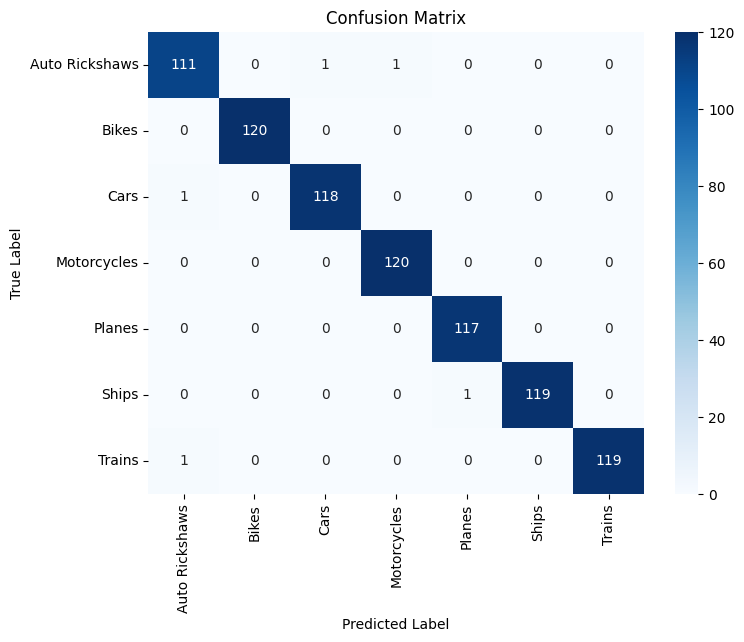

In [89]:
y_true = []  # Actual labels
y_pred = []  # Model predictions

for images, labels in test_batches:  # Loop through test data
    preds = r_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# **Predict on other unseen images**

## Load the model, define preprocess image function

In [90]:
#load model 
model = tf.keras.models.load_model(r'C:\Users\Anderson Yeo\Downloads\intern\efficientnet1.h5')

def preprocess_image(image_path, target_size=(240, 240)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    img_array = preprocess_input(img_array)  # Match EfficientNetB1 preprocessing
    return img_array

## Load image, preprocess the image and predict the images

In [93]:
# Load and preprocess the image
image_path = r"C:\Users\Anderson Yeo\Downloads\ship.jpg"
processed_img = preprocess_image(image_path)

# Make prediction
predictions = model.predict(processed_img)

# Get the class index with the highest probability
predicted_index = np.argmax(predictions, axis=1)[0]  # Get top class index

# Convert index to class name
predicted_label = class_names[predicted_index]

print(f"Predicted Vehicle Type: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicted Vehicle Type: Ships
